# These examples are heavily influenced by the documentation of the packages and the work of Rob Story

In [17]:
import pandas as pd
import numpy as np
%matplotlib inline
import dask as dask
import pymc3 as pm
dask.set_options(get=dask.async.get_sync)

In [18]:

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None)


In [19]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# I only have the standard library, I'm stuck on a restricted machine
* The Python standard library works kinda well. 
* We have to write our own converter though

In [20]:
# Altered version of Rob Story's example
import csv

conversion_map = {
    'age': int,
    'workclass': str,
    'fnlwgt': int,
    'education-categorical': str,
    'educ': int,
    'occupation': str,
    'sex': str,
    'capital-gain': float,
    'capital-loss': float,
    'hours': int,
    'native-country': str,
    'income': str
}
def converter(type_map, row):
    """Yep, we need to roll our own type conversions."""
    converted_row = {}
    for col, val in row.items():
        converter = type_map.get(col)
        if converter:
            converted_row[col] = converter(val)
        else:
            converted_row[col] = val
    return converted_row

with open('adult.csv', 'r') as f:
    reader = csv.DictReader(f)
    adult2 = [converter(conversion_map, r) for r in reader]

In [21]:
adult2[:2]

[{'': '0',
  'age': 39,
  'capital-loss': 0.0,
  'captial-gain': '2174',
  'educ': 13,
  'education-categorical': ' Bachelors',
  'fnlwgt': 77516,
  'hours': 40,
  'income': ' <=50K',
  'marital-status': ' Never-married',
  'native-country': ' United-States',
  'occupation': ' Adm-clerical',
  'relationship': ' Not-in-family',
  'sex': ' Male',
  'workclass': ' State-gov'},
 {'': '1',
  'age': 50,
  'capital-loss': 0.0,
  'captial-gain': '0',
  'educ': 13,
  'education-categorical': ' Bachelors',
  'fnlwgt': 83311,
  'hours': 13,
  'income': ' <=50K',
  'marital-status': ' Married-civ-spouse',
  'native-country': ' United-States',
  'occupation': ' Exec-managerial',
  'relationship': ' Husband',
  'sex': ' Male',
  'workclass': ' Self-emp-not-inc'}]

In [22]:
# defaultdict is awesome. defaultdict is awesome.
from collections import defaultdict

def grouper(grouping_col, seq):
    """People have definitely written a faster version than what I'm about to write
    Thanks to Rob Story for this one"""
    groups = defaultdict(lambda: defaultdict(list))
    for row in seq:
        group = groups[row[grouping_col]]
        for k, v in row.items():
            if k != grouping_col:
                group[k].append(v)
    return groups

In [23]:
groups = grouper('occupation', adult2)

# Let's say we wanted to group by occupation and get the mean hours worked. 


In [24]:
summary = {}
for group, values in groups.items():
    summary[group] = sum(values['hours']) / len(values['hours'])
summary

{' ?': 31.90613130765057,
 ' Adm-clerical': 37.55835543766578,
 ' Armed-Forces': 40.666666666666664,
 ' Craft-repair': 42.30422054159551,
 ' Exec-managerial': 44.9877029021151,
 ' Farming-fishing': 46.989939637826964,
 ' Handlers-cleaners': 37.947445255474456,
 ' Machine-op-inspct': 40.755744255744254,
 ' Other-service': 34.70166919575114,
 ' Priv-house-serv': 32.88590604026846,
 ' Prof-specialty': 42.38671497584541,
 ' Protective-serv': 42.87057010785824,
 ' Sales': 40.78109589041096,
 ' Tech-support': 39.432112068965516,
 ' Transport-moving': 44.65623043206011}

# We want the maximum age in the data set

In [25]:
def get_max_age():
    max_age = 0
    for row in adult2:
        if row['age'] > 1 and row['age'] > max_age:
            max_age = row['age']
    return max_age
get_max_age()

90

In [26]:
# More compact yet again: generator expression!
max(row['age'] for row in adult2 if row['age'] > 1)

90

In [27]:
# Which is faster? 
%timeit max(row['age'] for row in adult2 if row['age'] > 1)

10 loops, best of 3: 28.7 ms per loop


In [28]:
%timeit get_max_age()

10 loops, best of 3: 23.7 ms per loop


# I wanna count stuff in a functional way 
* I care about composibility, purity, all that Functional stuff 
* PSA: It's got a really cool API well worth a read - docs are here [toolz](http://toolz.readthedocs.org/en/latest/index.html)

In [29]:
import toolz as tz
accounts = [(1, 'Alice', 100, 'F'),(2, 'Bob', 200, 'M'),(3, 'Charlie', 150, 'M'),
            (4, 'Dennis', 50, 'M'),(5, 'Edith', 300, 'F'), (6, 'Alice', 150, 'F'), (7, 'Charlie', 350, 'M')]

* We can do things like compute frequencies. Let's look at the 2 column (python counts from 0) and the frequency of names

In [30]:
tz.frequencies([r[1] for r in accounts])

{'Alice': 2, 'Bob': 1, 'Charlie': 2, 'Dennis': 1, 'Edith': 1}

We want to reproduce 
```sql 
SELECT name, balance
FROM accounts
WHERE balance > 200``` 

In [31]:
# Toolz has currying!
import toolz.curried as tzc
tzc.pipe(accounts, 
         tzc.filter(lambda r: r[2] > 200),
         tzc.map(tzc.get([1,2])),dict)


{'Charlie': 350, 'Edith': 300}

In [32]:
adult2

[{'': '0',
  'age': 39,
  'capital-loss': 0.0,
  'captial-gain': '2174',
  'educ': 13,
  'education-categorical': ' Bachelors',
  'fnlwgt': 77516,
  'hours': 40,
  'income': ' <=50K',
  'marital-status': ' Never-married',
  'native-country': ' United-States',
  'occupation': ' Adm-clerical',
  'relationship': ' Not-in-family',
  'sex': ' Male',
  'workclass': ' State-gov'},
 {'': '1',
  'age': 50,
  'capital-loss': 0.0,
  'captial-gain': '0',
  'educ': 13,
  'education-categorical': ' Bachelors',
  'fnlwgt': 83311,
  'hours': 13,
  'income': ' <=50K',
  'marital-status': ' Married-civ-spouse',
  'native-country': ' United-States',
  'occupation': ' Exec-managerial',
  'relationship': ' Husband',
  'sex': ' Male',
  'workclass': ' Self-emp-not-inc'},
 {'': '2',
  'age': 38,
  'capital-loss': 0.0,
  'captial-gain': '0',
  'educ': 9,
  'education-categorical': ' HS-grad',
  'fnlwgt': 215646,
  'hours': 40,
  'income': ' <=50K',
  'marital-status': ' Divorced',
  'native-country': ' United

In [33]:
import toolz as tz
tz.frequencies([r['age'] for r in adult2])

{17: 395,
 18: 550,
 19: 712,
 20: 753,
 21: 720,
 22: 765,
 23: 877,
 24: 798,
 25: 841,
 26: 785,
 27: 835,
 28: 867,
 29: 813,
 30: 861,
 31: 888,
 32: 828,
 33: 875,
 34: 886,
 35: 876,
 36: 898,
 37: 858,
 38: 827,
 39: 816,
 40: 794,
 41: 808,
 42: 780,
 43: 770,
 44: 724,
 45: 734,
 46: 737,
 47: 708,
 48: 543,
 49: 577,
 50: 602,
 51: 595,
 52: 478,
 53: 464,
 54: 415,
 55: 419,
 56: 366,
 57: 358,
 58: 366,
 59: 355,
 60: 312,
 61: 300,
 62: 258,
 63: 230,
 64: 208,
 65: 178,
 66: 150,
 67: 151,
 68: 120,
 69: 108,
 70: 89,
 71: 72,
 72: 67,
 73: 64,
 74: 51,
 75: 45,
 76: 46,
 77: 29,
 78: 23,
 79: 22,
 80: 22,
 81: 20,
 82: 12,
 83: 6,
 84: 10,
 85: 3,
 86: 1,
 87: 1,
 88: 3,
 90: 43}

In [34]:

# What are our occupation counts?
tz.countby(lambda x: x['occupation'], adult2)

{' ?': 1843,
 ' Adm-clerical': 3770,
 ' Armed-Forces': 9,
 ' Craft-repair': 4099,
 ' Exec-managerial': 4066,
 ' Farming-fishing': 994,
 ' Handlers-cleaners': 1370,
 ' Machine-op-inspct': 2002,
 ' Other-service': 3295,
 ' Priv-house-serv': 149,
 ' Prof-specialty': 4140,
 ' Protective-serv': 649,
 ' Sales': 3650,
 ' Tech-support': 928,
 ' Transport-moving': 1597}

In [35]:
# What about our the max hours from above? Reduction!
def comparo(accum, row):
    hours = row['hours']
    if hours > accum:
        return hours
    else:
        return accum
    
tz.reduce(comparo, adult2, 0)

99

In [36]:

# We could have also threaded here
tz.thread_last(adult2, 
               (tz.map, lambda x: x['hours']), 
               max)

99

Let's compare the times a bit here.

In [37]:
%timeit tz.reduce(comparo, adult2, 0)

10 loops, best of 3: 30.7 ms per loop


In [38]:
%timeit tz.thread_last(adult2, (tz.map, lambda x: x['hours']),   max)

10 loops, best of 3: 31.3 ms per loop


Let's say we wanted to find out a count of all the occupations who have education greater than 15. 

In [39]:
# Toolz has currying!

import toolz.curried as tzc
tzc.pipe(adult2, 
         tzc.filter(lambda r: r['educ'] > 15),
         tzc.map(lambda r: (r['occupation'],)),
         tzc.countby(lambda r: r[0]),
         dict)

{' ?': 15,
 ' Adm-clerical': 5,
 ' Craft-repair': 2,
 ' Exec-managerial': 55,
 ' Farming-fishing': 1,
 ' Machine-op-inspct': 1,
 ' Other-service': 1,
 ' Prof-specialty': 321,
 ' Sales': 8,
 ' Tech-support': 3,
 ' Transport-moving': 1}

In [40]:
# Cleanest/best way: reduceby: Groupby + reduce
def increment(accum, row):
    if row['educ'] > 15:
        return accum + 1
    else:
        return accum

tz.reduceby('occupation', 
            increment,
            adult2, 0)       

{' ?': 15,
 ' Adm-clerical': 5,
 ' Armed-Forces': 0,
 ' Craft-repair': 2,
 ' Exec-managerial': 55,
 ' Farming-fishing': 1,
 ' Handlers-cleaners': 0,
 ' Machine-op-inspct': 1,
 ' Other-service': 1,
 ' Priv-house-serv': 0,
 ' Prof-specialty': 321,
 ' Protective-serv': 0,
 ' Sales': 8,
 ' Tech-support': 3,
 ' Transport-moving': 1}

# Xarray

In [41]:
import xarray as xray


In [42]:

arr = np.array([[1, 2, 3, 4], 
                [10, 20, 30, 40],
                [100, 200, 300, 400]])
dim0_coords = ['a', 'b', 'c']
dim1_coords = ['foo', 'bar', 'baz', 'qux']
da = xray.DataArray(arr, [('x', dim0_coords), ('y', dim1_coords)])
da

<xarray.DataArray (x: 3, y: 4)>
array([[  1,   2,   3,   4],
       [ 10,  20,  30,  40],
       [100, 200, 300, 400]])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c'
  * y        (y) <U3 'foo' 'bar' 'baz' 'qux'

In [43]:
da.values

array([[  1,   2,   3,   4],
       [ 10,  20,  30,  40],
       [100, 200, 300, 400]])

In [44]:
da[0:3]

<xarray.DataArray (x: 3, y: 4)>
array([[  1,   2,   3,   4],
       [ 10,  20,  30,  40],
       [100, 200, 300, 400]])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c'
  * y        (y) <U3 'foo' 'bar' 'baz' 'qux'

In [45]:
da.dims

('x', 'y')

In [46]:
da.coords

Coordinates:
  * x        (x) <U1 'a' 'b' 'c'
  * y        (y) <U3 'foo' 'bar' 'baz' 'qux'

In [47]:

# Indexing!
da.loc['b']

<xarray.DataArray (y: 4)>
array([10, 20, 30, 40])
Coordinates:
    x        <U1 'b'
  * y        (y) <U3 'foo' 'bar' 'baz' 'qux'

In [48]:
# Get a mean by label
da.mean(dim='y')

<xarray.DataArray (x: 3)>
array([   2.5,   25. ,  250. ])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c'

# Using Pandas 
* Pandas works very well for tabular data tasks. 
* The API is stabilizing
* We should see Pandas increasingly become a core member of the PyData stack. 

In [49]:
import pandas as pd

# The pipe operator
* One of the newest features in Pandas which is worth talking about is the pipe operator.
* This is very similar in style to Unix pipes. 
* I include it because it simplifies some of the ETL like code we often do in Pandas

In [50]:
column_names =['age', 'workclass', 'fnlwgt', 
                'education-categorical', 'educ', 
                'marital-status', 'occupation',
                'relationship', 'race', 'sex', 
                'captial-gain', 'capital-loss', 
                'hours', 'native-country', 
                'income']
adult = (pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None, names=column_names)
         .drop(['race'], axis='columns'))

adult.head()
adult.to_csv('adult.csv')



In [51]:
# One little example of the power of the Pandas API
adult.groupby('educ').mean()

,age,fnlwgt,captial-gain,capital-loss,hours
educ,,,,,
1,42.764706,235889.372549,898.392157,66.490196,36.647059
2,46.142857,239303.000000,125.875000,48.327381,38.255952
3,42.885886,232448.333333,176.021021,68.252252,38.897898
4,48.445820,188079.171827,233.939628,65.668731,39.366873
5,41.060311,202485.066148,342.089494,28.998054,38.044747
6,37.429796,196832.465166,404.574491,56.845659,37.052519
7,32.355745,194928.077447,215.097872,50.079149,33.925957
8,32.000000,199097.508083,284.087760,32.337182,35.780600
9,38.974479,189538.739739,576.800114,70.466622,40.575374


* I want to create a new column, quickly and in a fast way without harming my data integrity.
* One of the coolest new features in Pandas is the assign operator. It makes the API really easy to use, 
especially with the pipe operator mentioned elsewhere in the presentation.

In [52]:
adult.assign(age2 = lambda x: np.square(x.age))

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,sex,captial-gain,capital-loss,hours,native-country,income,age2
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K,1521
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K,2500
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K,1444
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K,2809
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K,784
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,Female,0,0,40,United-States,<=50K,1369
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Female,0,0,16,Jamaica,<=50K,2401
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,45,United-States,>50K,2704
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,Female,14084,0,50,United-States,>50K,961
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,5178,0,40,United-States,>50K,1764


# Blaze
What is Blaze and why should I care?

The Blaze ecosystem is a set of libraries that help users store, describe, query and process data. It is composed of the following core projects:

* Blaze: An interface to query data on different storage systems
* Dask: Parallel computing through task scheduling and blocked algorithms
* Datashape: A data description language
* DyND: A C++ library for dynamic, multidimensional arrays
* Odo: Data migration between different storage systems

In [53]:
import blaze as bz


bz_adult = bz.symbol('adult2', bz.discover(adult))
type(bz_adult)

blaze.expr.expressions.Symbol

In [54]:
mean_age = bz.by(bz_adult.occupation, price=bz_adult.age.mean())
hours_count = bz.by(bz_adult[bz_adult.hours > 35].educ,
                      count=bz_adult.workclass.count())



In [55]:
# We haven't actually computed anything yet!
# Let's make Pandas compute it. 
bz.compute(mean_age, adult)

,occupation,price
0,?,40.882800
1,Adm-clerical,36.964456
2,Armed-Forces,30.222222
3,Craft-repair,39.031471
4,Exec-managerial,42.169208
5,Farming-fishing,41.211268
6,Handlers-cleaners,32.165693
7,Machine-op-inspct,37.715285
8,Other-service,34.949621
9,Priv-house-serv,41.724832


In [56]:
# We have here the count of number of years of education by a certain filter of greater than 35 hours of work per week. 
%timeit bz.compute(hours_count, adult)

10 loops, best of 3: 77.5 ms per loop


In [57]:
adult = adult.rename(columns={"education-categorical":"educationcategorical", 
                              "marital-status":'maritalstatus', "captial-gain":'captialgain', "capital-loss":"capitalloss",
                              "native-country":"nativecountry"})


In [58]:
# Blaze/Odo make it easy to move data between containers
# Note that we have an empty table already created
pg_datasource = bz.odo(adult, "postgresql://peadarcoyle@localhost/pydata::adult2")
# Now we're going to use Postgres as our computation engine
result = bz.compute(hours_count, pg_datasource)
%timeit result



The slowest run took 13.11 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 143 ns per loop


In [59]:
# I don't want a selectable. I want a DataFrame
# odo again
%timeit bz.odo(bz.compute(hours_count, pg_datasource), pd.DataFrame)

1 loop, best of 3: 260 ms per loop


**Observation**, the compute time with Postgres is slightly quicker than the compute time with dataframes. You could also use other backends such as Spark to do this. Blaze is very powerful, the ability to seperate your compute engine and your user interface is very powerful. 



# Exploring Point of Interests with Dask and Pandas
* Based on Jake Vanderplas and his excellent blog.

Recently we've been looking at the PyData ecosystem, and there are many interesting tools such as BColz and Biggus/. 
Dask is a very versatile tool that allows out-of-core dataframes without learning a whole host of other techniques. Under the hood, Dask simply uses standard Python, NumPy, and Pandas commands on each chunk, and transparently executes operations and aggregates results so that you can work with datasets that are larger than your machine's memory.

In this notebook, I'll take a look at how dask can be useful when looking at a large dataset: the full extracted points of interest from OpenStreetMap. We will use Dask to manipulate and explore the data, and also see the use of matplotlib's Basemap toolkit to visualize the results on a map.

The data points that will be drawn are pub locations extracted from OpenStreetMap and provided by osm-x-tractor.
When you download and extract the Points Of Interest (POI) dataset as a CSV file it has a file size of about 800 MB and more than 9 million entries for different types of locations. To filter out only the locations tagged as pubs you can use csvgrep, which is part of the csvkit toolkit.
csvgrep -c amenity -m pub POIWorld.csv > POIWorld-pub.csv

The resulting CSV file is much smaller with a size of 7.7 MB and contains a little more than 120,000 entries for pub locations all over the world. Since the coverage varies across countries and regions, I chose to limit the map to Britain and Ireland where POI coverage seems quite comprehensive and there are a lot of pubs. Who could have thought?
Next we load the required libraries and define a function that checks whether a given location tuple is within the given bounding box.
https://jakevdp.github.io/blog/2015/08/14/out-of-core-dataframes-in-python/


In [60]:
import dask as dask
dask.set_options(get=dask.async.get_sync)
nrows = sum(1 for _ in open('POIWorld.csv'))
nrows

9140114

In [61]:
import numpy as np

# create an array of normally-distributed random numbers
a = np.random.randn(1000)

# multiply this array by a factor
b = a * 4

# find the minimum value
b_min = b.min()
print(b_min)

-11.8917670891


In [62]:
import dask.array as da

# create a dask array from the above array
a2 = da.from_array(a, chunks=200)

# multiply this array by a factor
b2 = a2 * 4

# find the minimum value
b2_min = b2.min()
print(b2_min)

dask.array<p_reduc..., shape=(), dtype=float64, chunksize=()>


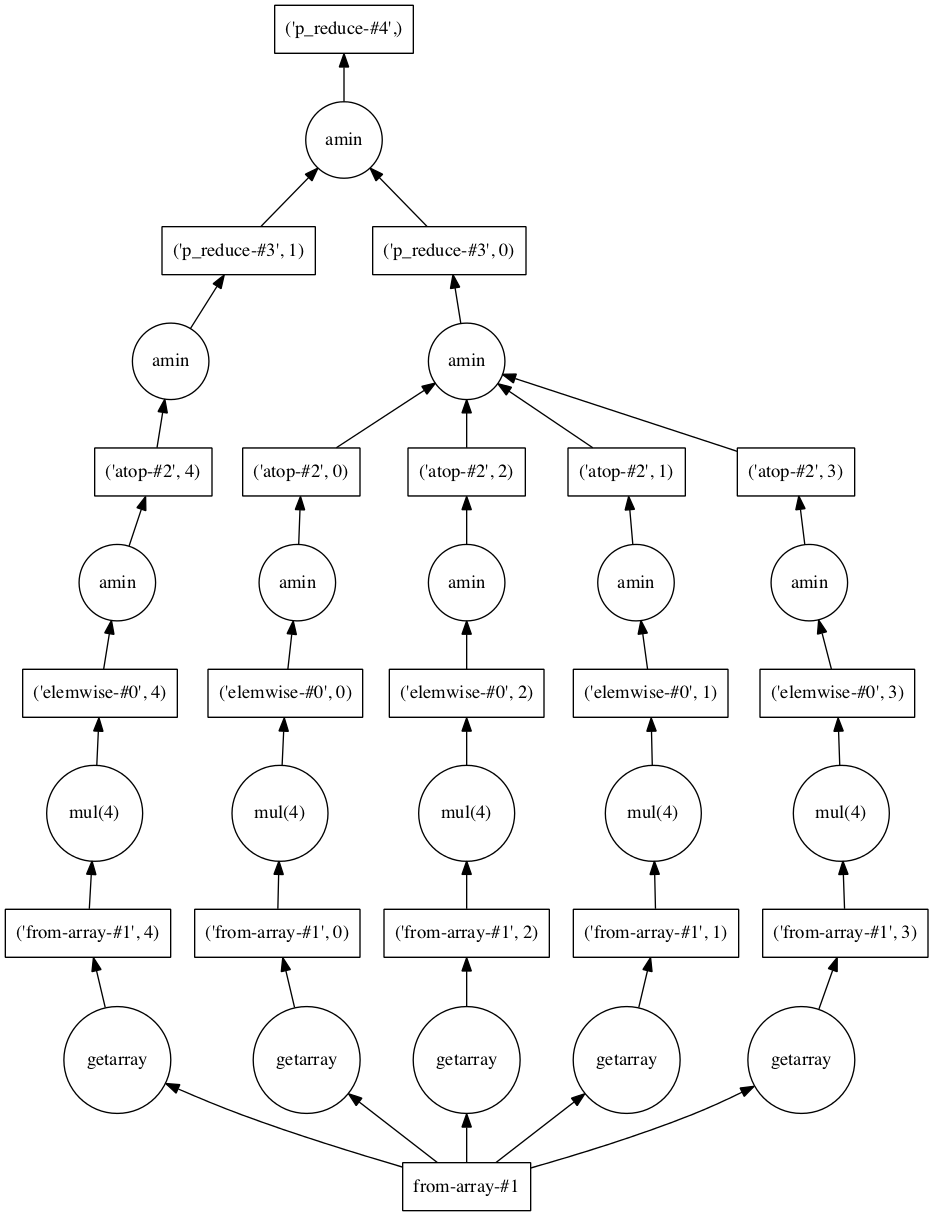

In [63]:
#With dask you can see how dask works :) 
from dask.dot import dot_graph
dot_graph(b2_min.dask)

In [64]:
import pandas as pd
data = pd.read_csv('POIWorld.csv', nrows=3000000)
data.columns
data.amenity.value_counts()

/Users/peadarcoyle/anaconda/envs/pydataamsterdam/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


place_of_worship             248985
school                       199875
bench                        132532
restaurant                   120449
grave_yard                   113132
parking                      111135
post_box                      93335
fuel                          86591
recycling                     51791
bank                          48477
fast_food                     46517
pub                           44977
telephone                     44622
cafe                          43699
post_office                   41622
pharmacy                      41478
hospital                      36130
bicycle_parking               27100
fire_station                  26170
toilets                       23948
atm                           23355
drinking_water                21000
police                        19655
shelter                       17780
library                       17515
hunting_stand                 17243
kindergarten                  16036
waste_basket                

In [65]:
from dask import dataframe as dd
columns = ["name", "amenity", "Longitude", "Latitude"]
data = dd.read_csv('POIWorld.csv', usecols=columns)
data

dd.DataFrame<read-csv-POIWorld.csv-805c83c59787385c1a1443421473c417, divisions=(None, None, None, ..., None, None)>

In [66]:
with_name = data[data.name.notnull()]


In [67]:
with_amenity = data[data.amenity.notnull()]

In [68]:
#I want to tell if this is a School or not and then plot it on a graph
is_school = with_amenity.amenity.str.contains('[Ss]chool')
school = with_amenity[is_school]
dd.compute(school.amenity.count())

(342025,)

In [69]:
lon, lat = dd.compute(school.Longitude, school.Latitude)
%matplotlib inline

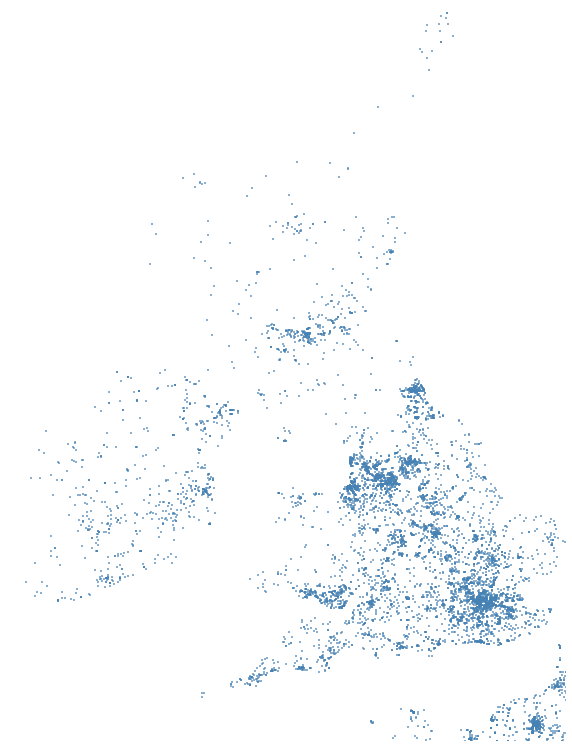

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
fig, ax = plt.subplots(figsize=(10, 15))
m = Basemap(projection='mill',
            lon_0=-5.23636, lat_0=53.866772,
            llcrnrlon=-10.65073, llcrnrlat=49.16209,
            urcrnrlon=1.76334, urcrnrlat=60.860699)
m.drawmapboundary(fill_color='#ffffff', linewidth=.0)
x, y = m(lon.values, lat.values)
m.scatter(x, y, s=1, marker=',', color="steelblue", alpha=0.6);

# Bcolz 
* What if I have medium data/ lots of data and databases aren't quite quick enough.
* I want to compress my data and use it for in-memory computations. 
* This is very typical as an application for time series data. 
* An example below is copied from Jagged documentation and Jagged is built on top of Bcolz.
* Castra is also built on bcolz. 

In [71]:
import bcolz

In [72]:
adult_df = adult[['age', 'workclass', 'educ', 'occupation', 'sex', 'hours']]

In [73]:

dc = bcolz.ctable.fromdataframe(adult_df)
dc

ctable((32561,), [('age', '<i8'), ('workclass', 'S17'), ('educ', '<i8'), ('occupation', 'S18'), ('sex', 'S7'), ('hours', '<i8')])
  nbytes: 2.05 MB; cbytes: 1.63 MB; ratio: 1.26
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[(39, b' State-gov', 13, b' Adm-clerical', b' Male', 40)
 (50, b' Self-emp-not-inc', 13, b' Exec-managerial', b' Male', 13)
 (38, b' Private', 9, b' Handlers-cleaners', b' Male', 40) ...,
 (58, b' Private', 9, b' Adm-clerical', b' Female', 40)
 (22, b' Private', 9, b' Adm-clerical', b' Male', 20)
 (52, b' Self-emp-inc', 9, b' Exec-managerial', b' Female', 40)]

In [74]:
dc.cols

age : carray((32561,), int64)
  nbytes: 254.38 KB; cbytes: 256.00 KB; ratio: 0.99
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[39 50 38 ..., 58 22 52]
workclass : carray((32561,), |S17)
  nbytes: 540.56 KB; cbytes: 303.83 KB; ratio: 1.78
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[b' State-gov' b' Self-emp-not-inc' b' Private' ..., b' Private'
 b' Private' b' Self-emp-inc']
educ : carray((32561,), int64)
  nbytes: 254.38 KB; cbytes: 256.00 KB; ratio: 0.99
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[13 13  9 ...,  9  9  9]
occupation : carray((32561,), |S18)
  nbytes: 572.36 KB; cbytes: 338.49 KB; ratio: 1.69
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[b' Adm-clerical' b' Exec-managerial' b' Handlers-cleaners' ...,
 b' Adm-clerical' b' Adm-clerical' b' Exec-managerial']
sex : carray((32561,), |S7)
  nbytes: 222.58 KB; cbytes: 256.00 KB; ratio: 0.87
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[b'

In [75]:

dsize = dc.cbytes / 2**20.
print("Total size for the ctable: {} MB".format(dsize))
print("Compression ratio the ctable: {}".format((dc.nbytes / float(dc.cbytes))))

Total size for the ctable: 1.6272649765014648 MB
Compression ratio the ctable: 1.2594573908273463


In [76]:
#dc.cols
# You can do DataFrame-like stuff
dc['workclass' == ' State-gov']

(39, b' State-gov', 13, b' Adm-clerical', b' Male', 40)

Let's check the in-memory Ctable functionality
Since this is integers it has *high compression* 
The example dataset I produce is 1GB in size. 

In [77]:
%%time

N = 100000 * 1000
print(N)
import bcolz
ct = bcolz.fromiter(((i, i ** 2) for i in range(N)),
                    dtype="i4, i8",
                    count=N,
                    cparams=bcolz.cparams(clevel=9))

100000000
CPU times: user 58.4 s, sys: 1.15 s, total: 59.5 s
Wall time: 58 s


In [78]:
ct

ctable((100000000,), [('f0', '<i4'), ('f1', '<i8')])
  nbytes: 1.12 GB; cbytes: 151.84 MB; ratio: 7.54
  cparams := cparams(clevel=9, shuffle=True, cname='blosclz')
[(0, 0) (1, 1) (2, 4) ..., (99999997, 9999999400000009)
 (99999998, 9999999600000004) (99999999, 9999999800000001)]

In [79]:
%time ct.eval('f0 ** 2 + sqrt(f1)')

CPU times: user 4.38 s, sys: 1.94 s, total: 6.31 s
Wall time: 1.21 s


carray((100000000,), float64)
  nbytes: 762.94 MB; cbytes: 347.33 MB; ratio: 2.20
  cparams := cparams(clevel=5, shuffle=True, cname='blosclz')
[  0.00000000e+00   2.00000000e+00   6.00000000e+00 ...,   1.37491943e+09
   1.57491943e+09   1.77491942e+09]

# There are some tools built on top of Bcolz.
Like **Jagged** 
* What is Jagged for? 
* What are its attributes? 
* Jagged is an ongoing amateur project exploring the storage panorama for datasets containing (large amounts of) arrays with the same type and number of columns, but varying number of rows. Examples of such datasets for which jagged has been used are collections of multivariate timeseries (short animal behaviour snippets) and collections of molecules (represented as varying length strings).

* Jagged aims to help analyzing data in the laptop and the cluster, in batch or interactively, providing a very lightweight store. Jagged provides fast retrieval of array subsets for many-GB datasets containing millions of rows. 

In [80]:
import os.path as op
import shutil
import numpy as np
import pandas as pd
import tempfile
from jagged.mmap_backend import JaggedByMemMap
from jagged.blosc_backend import JaggedByBlosc

# A Jagged instance is all you need
mmap_dir = tempfile.mkdtemp('mmap')
jagged = JaggedByMemMap(op.expanduser(path=mmap_dir))
# You can drop here any JaggedRawStore implementation you want to

# Generate a random dataset
print('Creating a random dataset...')
rng = np.random.RandomState(0)
num_arrays = 1000
max_length = 2000
num_columns = 100
originals = [rng.randn(rng.randint(0, max_length), num_columns)
             for _ in range(num_arrays)]

# Add these to the store ("with" context is usually optional, but recommended)
print('Populating the jagged store...')
with jagged:
    indices = list(map(jagged.append, originals))

# Some jagged stores optimize queries retrieving arrays by their insertion order
# Retrieval speed should not suffer much even with random queries
shuffled_indices = rng.permutation(indices).tolist()
shuffled_originals = [originals[i] for i in shuffled_indices]

# What do we have in store?
print('Number of arrays: %d, number of rows: %d' % (jagged.narrays, jagged.nrows))
# Out: Number of arrays: 200, number of rows: 193732
print('Jagged shape=%r, dtype=%r, order=%r' %
      (jagged.shape, jagged.dtype, jagged.order))
# Out: Jagged shape=(193732, 50), dtype=dtype('float64'), order='C'

# Check roundtrip
roundtrippeds = jagged.get(shuffled_indices)
for original, roundtripped in zip(shuffled_originals, roundtrippeds):
    assert np.array_equal(original, roundtripped)
print('Roundtrip checks pass')

# Jagged stores self-identified themselves (using whatami)
print(jagged.what().id())
# Out: JaggedByMemMap(autoviews=True,contiguity=None)

# Jagged stores can be iterated in chunks (see iter)
for original, roundtripped in zip(originals, jagged):
    assert np.array_equal(original, roundtripped[0])
print('Roundtrip checks for iteration pass')

# Some jagged stores allow to retrieve arbitrary rows without penalty
# (i.e. without retrieving the whole containing array).
# These are marked as "linear" in the store feature matrix.
# You do so by passing a list of (base, size) segments.
some_rows = jagged.get([[3, 22], [45, 1000]])
assert len(some_rows[1]) == 1000
assert np.array_equal(some_rows[0], originals[0][3:25])
print('Roundtrip checks for row retrieval pass')

# Some jagged stores allow to be lazy retrieving the arrays.
# On top of that, the MemMap implementation allow memmapped arrays.
# Can be handy to have long lists of views in memory
# while letting the OS managing memory fetching and eviction for us.
jbmm = JaggedByMemMap(op.expanduser(path=mmap_dir),
                      autoviews=True,
                      contiguity='auto')
print('Retrieving %d arrays...' % (len(shuffled_indices) * 100))
many_arrays = jbmm.get(shuffled_indices * 100)
# This will work also for pandas DataFrames as long as
# "copy=True" is honored by the pandas constructor
# that is, the dtype of the arrays is simple),
print('Making %d dataframes...' % (len(shuffled_indices) * 100))
columns = pd.Index(np.arange(num_columns))
dfs = [pd.DataFrame(data=array, columns=columns, copy=False)
       for array in many_arrays]
print('Checking roundtrip...')
for original, roundtripped in zip(shuffled_originals * 100, dfs):
    assert np.array_equal(original, roundtripped)
print('Roundtrip checks for lazy dataframes pass')

# Jagged stores can be populated from other jagged stores
blosc_dir = tempfile.mkdtemp('mmap')
jbb = JaggedByBlosc(path=blosc_dir)
print('Saving compressed (although these data are not compressable)...')
jbb.append_from(jagged)
for a_from_mmap, a_from_blosc in zip(jbb, jagged):
    assert np.array_equal(a_from_mmap, a_from_blosc)
print(jbb.what().id())
print('Roundtrip checks for compressed arrays pass')
# Out: JaggedByBlosc(compressor=BloscCompressor(cname='lz4hc',
#                                               level=5,
#                                               n_threads=1,
#                                               shuffle=True))

# We are done, cleanup
shutil.rmtree(mmap_dir, ignore_errors=True)
shutil.rmtree(blosc_dir, ignore_errors=True)

Creating a random dataset...
Populating the jagged store...
Number of arrays: 1000, number of rows: 1022477
Jagged shape=(1022477, 100), dtype=dtype('float64'), order='C'
Roundtrip checks pass
JaggedByMemMap(autoviews=True,contiguity=None)
Roundtrip checks for iteration pass
Roundtrip checks for row retrieval pass
Retrieving 100000 arrays...
Making 100000 dataframes...
Checking roundtrip...
Roundtrip checks for lazy dataframes pass
Saving compressed (although these data are not compressable)...
JaggedByBlosc(compressor=BloscCompressor(cname='lz4hc',level=5,n_threads=1,shuffle=True))
Roundtrip checks for compressed arrays pass


# Ibis
* If you want to split your expression engine (pandas like syntax) from your compute engine (in memory, versus Impala/ Sqlite)
* There are similarities with this project and Blaze. 
* Ibis is a new Python data analysis framework with the goal of enabling data scientists and data engineers to be as productive working with big data as they are working with small and medium data today. In doing so, we will enable Python to become a true first-class language for Apache Hadoop, without compromises in functionality, usability, or performance. Having spent much of the last decade improving the usability of the single-node Python experience (with pandas and other projects), we are looking to achieve:

* 100% Python end-to-end user workflows
* Native hardware speeds for a broad set of use cases
* Full-fidelity data analysis without extractions or sampling
* Scalability for big data
* Integration with the existing Python data ecosystem (pandas, scikit-learn, NumPy, and so on)


# Demo 
* For our demo we'll look at Pokemon data. 
[Pokemon source](https://github.com/danmane/PokemonSQLTutorial)


In [81]:
import ibis
ibis.options.interactive = True

con = ibis.sqlite.connect('data/veekun-pokedex.sqlite')
con


In [82]:
con.list_tables()

['abilities',
 'ability_changelog',
 'ability_changelog_prose',
 'ability_flavor_text',
 'ability_names',
 'ability_prose',
 'berries',
 'berry_firmness',
 'berry_firmness_names',
 'berry_flavors',
 'conquest_episode_names',
 'conquest_episode_warriors',
 'conquest_episodes',
 'conquest_kingdom_names',
 'conquest_kingdoms',
 'conquest_max_links',
 'conquest_move_data',
 'conquest_move_displacement_prose',
 'conquest_move_displacements',
 'conquest_move_effect_prose',
 'conquest_move_effects',
 'conquest_move_range_prose',
 'conquest_move_ranges',
 'conquest_pokemon_abilities',
 'conquest_pokemon_evolution',
 'conquest_pokemon_moves',
 'conquest_pokemon_stats',
 'conquest_stat_names',
 'conquest_stats',
 'conquest_transformation_pokemon',
 'conquest_transformation_warriors',
 'conquest_warrior_archetypes',
 'conquest_warrior_names',
 'conquest_warrior_rank_stat_map',
 'conquest_warrior_ranks',
 'conquest_warrior_skill_names',
 'conquest_warrior_skills',
 'conquest_warrior_specialties',


In [83]:
#Let us do some pandas like value counts on SQLite (could also be on Impala)
# Firstly we connect to the table pokemon_types
types = con.table('pokemon_types')
types.info()
types.pokemon_id.value_counts()

Table rows: 1179

Column      Type                 Non-null #
------      ----                 ----------
pokemon_id  int64[non-nullable]  1179      
type_id     int64[non-nullable]  1179      
slot        int64[non-nullable]  1179      

     pokemon_id  count
0             1      2
1             2      2
2             3      2
3             4      1
4             5      1
5             6      2
6             7      1
7             8      1
8             9      1
9            10      1
10           11      1
11           12      2
12           13      2
13           14      2
14           15      2
15           16      2
16           17      2
17           18      2
18           19      1
19           20      1
20           21      2
21           22      2
22           23      1
23           24      1
24           25      1
25           26      1
26           27      1
27           28      1
28           29      1
29           30      1
..          ...    ...
754       10034      2
755       10035      2
756       10036      1
757       10037      1
758       10038      2
759       10039      1
760       10040      2
761       10041      2
762       10042      2
763       10043      2
764       10044      1
765       1

In [84]:
types.pokemon_id.mean()

1250.70737913486

In [85]:
# Let's find the maximum pokemon id
types.pokemon_id.max()

10063

In [86]:
# Let's find the minimum pokemon id
types.pokemon_id.min()

1

Let us connect to another table just to show the functionality

In [87]:
moves = con.table('pokemon_moves')

In [88]:
# Let's look at the move_id and how they are distributed
# Using a pandas like syntax
moves.move_id.value_counts()

     move_id  count
0          1    389
1          2    111
2          3    263
3          4     68
4          5    408
5          6     64
6          7    734
7          8    768
8          9    798
9         10    701
10        11    120
11        12    109
12        13    175
13        14   1373
14        15   1962
15        16    339
16        17    341
17        18    342
18        19    679
19        20    178
20        21    433
21        22    168
22        23    359
23        24    237
24        25    347
25        26     42
26        27     50
27        28    770
28        29   1249
29        30    163
..       ...    ...
579      582      2
580      583     30
581      584     16
582      585     20
583      586      6
584      587      1
585      588      2
586      589     19
587      590    765
588      591      1
589      592      2
590      593      2
591      594      2
592      595      2
593      596      2
594      597      1
595      598     10
596      599     12


# Bayesian Logistic Regression
* It is outside of scope to explain in depth what all this means. But you can look at 
[Bayesian Logreg](https://pymc-devs.github.io/pymc3/Bayesian_LogReg/)
* I want to do a Bayesian Logistic regression model in PyData, how do I do it?
* Use **PyMC3** 

In [89]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None, names=['age', 'workclass', 'fnlwgt', 
                'education-categorical', 'educ', 
                'marital-status', 'occupation',
                'relationship', 'race', 'sex', 
                'captial-gain', 'capital-loss', 
                'hours', 'native-country', 
                'income'])

In [90]:
def plot_traces(traces, retain=1000):
    ''' 
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

In [91]:
data = data[~pd.isnull(data['income'])]

In [92]:
data[data['native-country']==" United-States"]
income = 1 * (data['income'] == " >50K")
age2 = np.square(data['age'])
data = data[['age', 'educ', 'hours']]
data['age2'] = age2
data['income'] = income

In [93]:
import pymc3 as pm
print(pm.__version__)

3.0


In [ ]:
with pm.Model() as logistic_model:
    pm.glm.glm('income ~ age + age2 + educ + hours', data, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, pm.NUTS(), progressbar=True)


Applied logodds-transform to p and added transformed p_logodds to model.
 [--                7%                  ] 147 of 2000 complete in 34.3 sec

In [ ]:
plot_traces(trace_logistic_model, retain=1000)

# That's it, up and down the PyData stack for 2016. 